In [1]:
import datasets as ds
from redditqa.data.smart_filter import question_filter
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-12 19:27:57.378120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 19:27:57.378157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 19:27:57.379205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 19:27:57.384256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to 

In [2]:
dataset = ds.load_from_disk("/scratch1/redditqa/cached_datasets/AskHistorians_question_filter_probabilities.jsonl")

In [3]:
dataset[0]["graded_output"]

[{'probability': 5.414398884795446e-08, 'token_id': 9780, 'token_str': 'yes'},
 {'probability': 3.878222742059734e-06, 'token_id': 1510, 'token_str': 'no'},
 {'probability': 5.9029262047261e-05, 'token_id': 5613, 'token_str': 'Yes'},
 {'probability': 0.006459745578467846, 'token_id': 2501, 'token_str': 'No'},
 {'probability': 2.7870935781493245e-08, 'token_id': 28724, 'token_str': 'y'},
 {'probability': 3.152028327235712e-08, 'token_id': 28711, 'token_str': 'n'},
 {'probability': 0.6537843346595764,
  'token_id': 1014,
  'token_str': 'generated: The'}]

In [7]:
def parse_graded_output(row):
    graded_output = {
        entry["token_str"]: entry["probability"]
        for entry in row["graded_output"]
    }
    return {"prob_good": max(graded_output["Yes"], graded_output["yes"], graded_output["y"]), 
            "prob_bad": max(graded_output["No"], graded_output["no"], graded_output["no"])}

dataset = dataset.map(parse_graded_output, batched=False, load_from_cache_file=False)

Map: 100%|██████████| 69262/69262 [00:12<00:00, 5414.24 examples/s]


In [8]:
df = pd.DataFrame.from_dict({
    "prob_good": dataset["prob_good"],
    "prob_bad": dataset["prob_bad"]
})

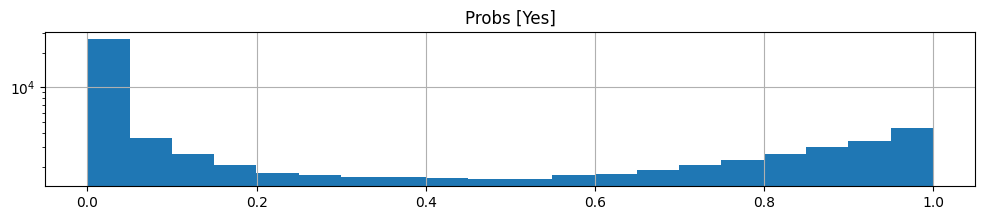

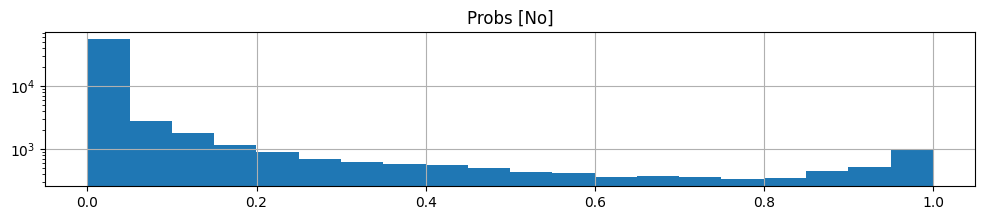

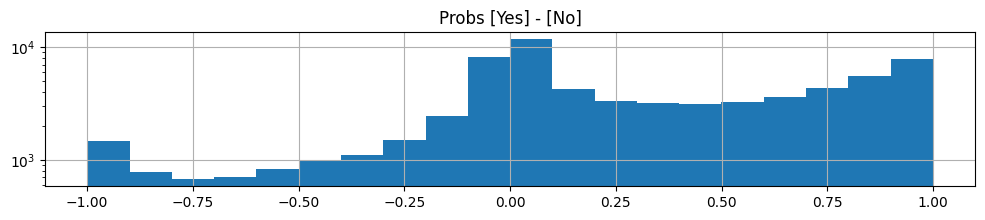

In [9]:
df.prob_good.hist(bins=20, log=True, figsize=(12, 2))
plt.title("Probs [Yes]")
plt.show()
df.prob_bad.hist(bins=20, log=True, figsize=(12, 2))
plt.title("Probs [No]")
plt.show()
(df.prob_good - df.prob_bad).hist(bins=20, log=True, figsize=(12, 2))
plt.title("Probs [Yes] - [No]")
plt.show()

In [10]:
quantiles = (df.prob_good - df.prob_bad).quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
quantiles

0.1   -0.274939
0.2   -0.031380
0.3    0.001499
0.4    0.052628
0.5    0.194914
0.6    0.404778
0.7    0.619343
0.8    0.791011
0.9    0.913311
dtype: float64

In [14]:
dataset_filtered = dataset.filter(lambda row: row["prob_good"] > quantiles[0.6])
dataset_filtered

Filter: 100%|██████████| 27788/27788 [00:02<00:00, 12395.93 examples/s]


Dataset({
    features: ['question_created_utc', 'question_retrieved_on', 'question_deleted', 'question_title', 'question_selftext', 'question_score', 'question_char_length', 'question_selftext_char_length', 'answers', 'graded_output', 'prob_good', 'prob_bad'],
    num_rows: 27788
})

In [15]:
pd.Series(dataset_filtered["prob_good"]).describe()

count    27788.000000
mean         0.758694
std          0.173619
min          0.404789
25%          0.618388
50%          0.790444
75%          0.912961
max          0.999216
dtype: float64

In [16]:
dataset_filtered["question_title"]

['Are there any Major or semi- major generally accepted historic events that we only know about due to secondary sources?',
 'What are the most common and prevalent existence of paradigms in historiography, and how do they affect the study of history?',
 "I'm interested in naval warfare. What battles are the most interesting in this regard?",
 'The French Revolution - Which socioeconomic factors caused it?',
 'Who were some of the most corrupt Popes and clergymen in history?',
 'Why were medieval/early modern Christian philosophers so focused on ancient Greek pagan philosophers, specifically Plato and Aristotle?',
 'Did a lot of people die of lung cancer in the past because of open fire places in their houses?',
 'What are some examples of the use of psychedelic drugs in history?',
 'How was the Warsaw Uprising, if at all, portrayed in contemporary media?',
 'Religious sects of Reformation England: Who were they and what did they believe?',
 'Reddit, what were the perspectives of the B

In [22]:
interesting_samples = [
    'I started /r/Simulate, a new idea collective dedicated to dreaming the most realistic geopolitical history simulator ever and playing it as a 4X strategy game. Can you submit some sources dedicated to quantitative methods of modeling history or any era?',
    "Has there ever been a case of a government completely restarting it's bureaucracy, without something like a revolution?"
]
dataset_filtered.filter(lambda row: row["question_title"] in interesting_samples)[0]

{'question_created_utc': 1349145619000,
 'question_retrieved_on': 1413529843000,
 'question_deleted': False,
 'question_title': 'I started /r/Simulate, a new idea collective dedicated to dreaming the most realistic geopolitical history simulator ever and playing it as a 4X strategy game. Can you submit some sources dedicated to quantitative methods of modeling history or any era?',
 'question_selftext': "Hello everybody, thanks for your time!\nI'm starting somewhat of a unique project on Reddit, /r/Simulate and could use the help of some experienced researchers, historians, and professionals of all walks of life. We want to make an engine that generates plate tectonics, human language, culture, everything. We want to utilize academic models, automated agents, and tons of other cool stuff.\n\nI've been meditating on what a global history simulation with a universal culture &amp; language engine would look like; and how it could be implemented as a game with educational benefits. I outli